# ¿Qué aprenden las redes neuronales?

Durante el ultimo año he esta aprendiendo sobre aprendizaje de maquina (ML) específicamente en redes neuronales convencionales (CNN) aplicado a imágenes de resonancia magnética (MRI).
En este articulo voy a explorar como las CNN interpretan las imágenes que le damos de entrada y como las activaciones se propagan por las diferentes capas de la red.
Este articulo esta basado en este [post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) por Francois Chollet creador de Keras.

Las CNNs aprenden una serie de filtros que aplican a las imágenes de entrada para lograr un objetivo (ej clasificación, reconstrucción, etc)
Para poder interpretar como la red interpreta las imágenes es útil visualizar los filtros.
Nuestro objetivo sera buscar una imagen que maximice el activación de una de uno de los filtros en las capas convulucionales de la red. Esta técnica es util para corroborar que la red halla aprendido características pertinentes para resolver el problema.
Ademas es la técnica que se utiliza para generar las imágenes de [Deep Dream](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)

## Cargando la red

Vamos a usar un red U-net propuesta en el 2015 [[1]](https://arxiv.org/abs/1505.04597) para la segmentación de imágenes biomédica.
En esta red consta de dos partes, una primera compresora las imágenes reduciendo sus dimensiones y luego parte decodificadora que aumenta el tamaño de la imagen recuperando la imagen original.
La innovación en esta red esta en que tiene conexiones que conectan alternadamente las dos partes de la red facilitando el flujo de información a través de ella.

Durante el mes pasado la utilice para mejora la reconstrucción de imágenes de resonancia magnética.
Básicamente esta red toma una imagen *undersample* en el espacio de la frecuencia y la reconstruye para que no se noten los artefactos del [*aliasing*](https://es.wikipedia.org/wiki/Aliasing)[^1].
Esta red yo ya la configure y entrene usando imágenes simuladas (vivan los círculos y rectángulos) y la red completa con pesos esta disponible [aquí](https://drive.google.com/file/d/1v4uk8s5aU09g-iIidWJ97QbO2Uk2p1H8/view?usp=sharing).
Algunas imágenes del set de entrenamiento, la reconstrucción mejorada y su version con *aliasing*.

![Ejemplo de entrada, salida y valor verdadero de la red ](/assets/posts/visualizacion-filtros-keras/ej1.png)
![Ejemplo de entrada, salida y valor verdadero de la red ](/assets/posts/visualizacion-filtros-keras/ej2.png)
![Ejemplo de entrada, salida y valor verdadero de la red ](/assets/posts/visualizacion-filtros-keras/ej3.png)
![Ejemplo de entrada, salida y valor verdadero de la red ](/assets/posts/visualizacion-filtros-keras/ej4.png)


In [1]:
from keras.models import load_model
from keras.utils import get_file

modelpath = get_file("/content/model.h5", "https://drive.google.com/a/uc.cl/uc?export=download&id=1v4uk8s5aU09g-iIidWJ97QbO2Uk2p1H8")
print(modelpath)
model = load_model(modelpath)
model.summary()

Using TensorFlow backend.


/content/model.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
dconv64 (Conv2D)                (None, 128, 128, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv64_1 (BatchNormalization)   (None, 128, 128, 64) 256         dconv64[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 64)   0           conv6

Ya cargado el modelo, definimos una función que maximice uno de los filtros de la entrada.



In [0]:
from keras import backend as K

# definir un dicicionario con el nombre de cada capa
layer_dict = dict([(layer.name, layer) for layer in model.layers])
input_img = model.inputs[0]
layer_name = 'dconv64'
filter_index = 0  # cualquiera de los 64 filtros en esa capa

layer_output = layer_dict[layer_name].output
# Una funccion de costo que maximiza la activacion del filtro
loss = K.mean(layer_output[:, :, :, filter_index])


grads = K.gradients(loss, input_img)[0]

# es importante normalizar los gradientes
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# una funcion para calcular la los gradientes dada una imagen de entrada
iterate = K.function([input_img], [loss, grads])


Usando la funcion de Keras que definimos podemos subir en el gradiente buscando la imagen que maximice el filtro. Esto puede tomar unos cuantos segundos.

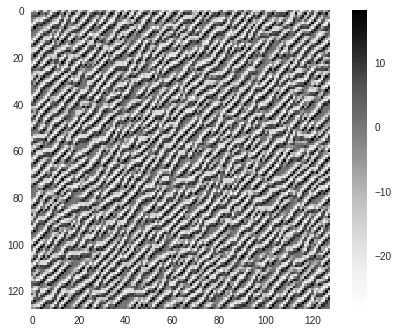

In [3]:
import numpy as np
import matplotlib.pyplot as plt

SIZE = 128
input_img_data = np.random.random((1, 128, 128, 1))

# iteramos
step = 1
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    
plt.imshow(input_img_data[0, ..., 0])
plt.colorbar()
plt.grid()
plt.show()


## Listo

Calculemos la maxima activación para algunos de los filtros en cada capa.


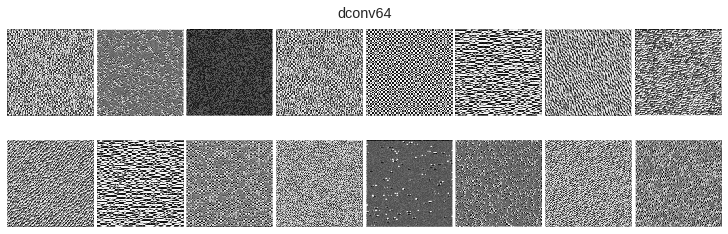

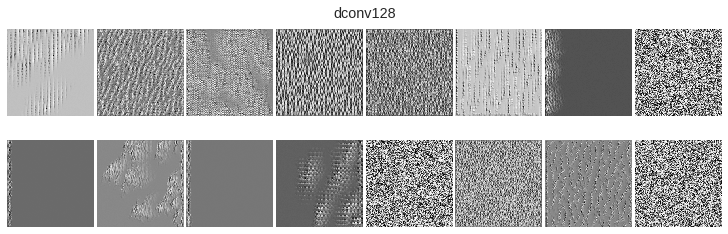

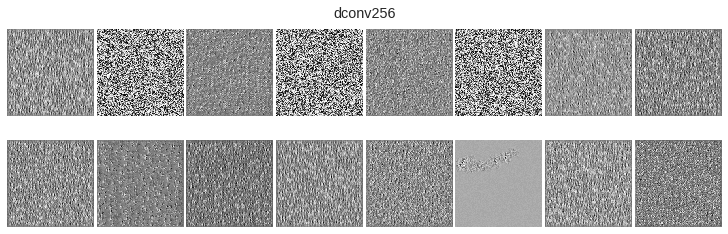

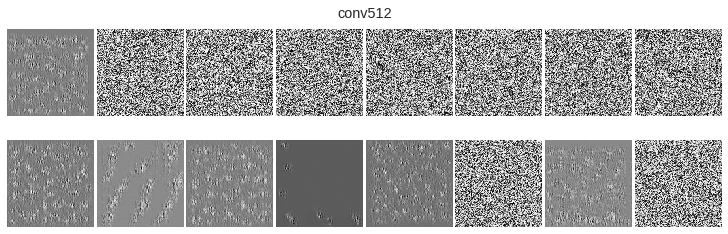

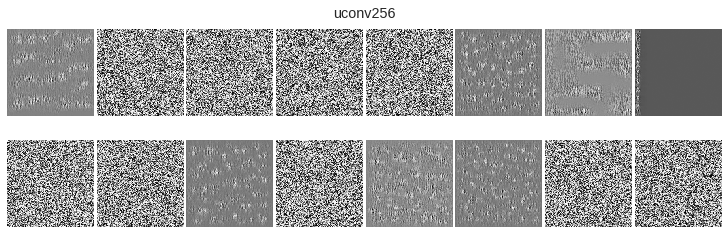

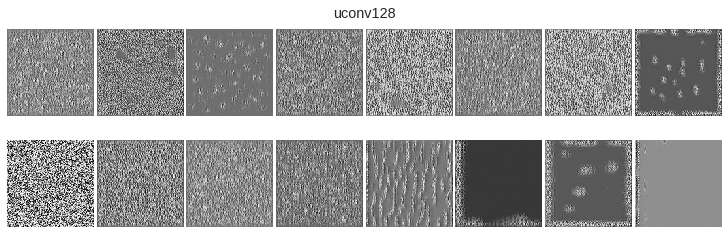

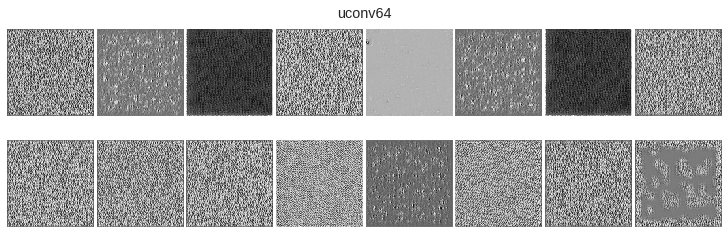

In [4]:
def visual(input_imag, layer_name, filter_index):
    
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, input_img)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_img], [loss, grads])
    
    input_img_data = np.random.random((1, 128, 128, 1)) * 2

    # iteramos
    step = 1
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    return input_img_data[0, ..., 0]

layers = [('dconv64', 64), ('dconv128', 128), ('dconv256', 256), ('conv512', 512), ('uconv256', 128), ('uconv128', 128), ('uconv64', 64)]

input_img = model.inputs[0]
for name, filt in layers:
  fig, ax = plt.subplots(2, 8, figsize=(10, 3.5))
  ax = ax.ravel()
  fig.suptitle(name)
  for a in ax:
    i = np.random.randint(0, filt)
    a.imshow(visual(input_img, name, i))
    a.set_xticks([])
    a.set_yticks([])

  fig.tight_layout(pad=0.25)
  fig.show()
  


La mayoría de los filtros son selectores de  lineas verticales y horizontales, lo que tiene sentido dada la forma del *aleasing*.
En las capas superiores las lineas se comienzan a separar más indicando que la detección esta a un nivel mas global.
Luego en las capas de *decoding* las activaciones se vuelven con una textura casi constante lo que refleja que se esta tratando de reconstruir la imagen.
Otra observación importante es lo que hay varios filtros dedicadas a manejar los bordes.

Ademas, existen varias capas que pareciera que detectan solo ruido por lo que probablemente se podrían reducir la cantidad de filtros y mantener la calidad de los resultados.

Es sorprendente lo poco que entendemos de como aprenden las redes neuronales.
Poder visualizar los filtros de nos abre una puerta para poder evaluar lo que realmente aprende nuestra red.
Pero es aun un area en donde hay mucho que investigar.

## DeepDream

Una de las aplicaciones interesante de esta  tecnología es la creación de imágenes de oníricas.
En lugar de partir con ruido si se parte de fotografiás y maximizando la activación de un filtro un filtro para generar imágenes que parecen venir de un sueño.

Si se activa uno de los primeros filtros comienzan a aparecer patrones simples como lineas o círculos.
Pero si se activan alguna de las capas más profundas comienzan a aparecer patrones más complejos que asemejan las clases con las que fue entrenada la red.
Imágenes de Google AI Blog 2015.

![Left: Original painting by Georges Seurat. Right: processed images by Matthew McNaughton, Software Engineer](https://4.bp.blogspot.com/-PK_bEYY91cw/VYIVBYw63uI/AAAAAAAAAlo/iUsA4leua10/s640/seurat-layout.png)

![Nubes](https://4.bp.blogspot.com/-FPDgxlc-WPU/VYIV1bK50HI/AAAAAAAAAlw/YIwOPjoulcs/s640/skyarrow.png)

Puedes [descargar](/assets/posts/filtros-vis/notenook.ipynb) este articulo como un cuaderno jupyter. El código del post original de Keras esta disponible en [GitHub](https://github.com/keras-team/keras/blob/master/examples/conv_filter_visualization.py)
